# CONUS Coasts

### US States and Coastlines

**Census TIGER (Topologically Integrated Geographic Encoding and Referencing database)**

In [1]:
import os
import warnings
from pathlib import Path

import geopandas as gpd

warnings.filterwarnings("ignore", message=".*initial implementation of Parquet.*")
root = Path("input_data")
os.makedirs(root, exist_ok=True)
BASE_PLOT = {"facecolor": "k", "edgecolor": "b", "alpha": 0.2, "figsize": (18, 9)}
CRS = "esri:102008"


def tiger_shp_2020(data):
    url = f"https://www2.census.gov/geo/tiger/TIGER2020/{data.upper()}/tl_2020_us_{data}.zip"
    return gpd.read_file(url)


cfile = Path(root, "us_state.feather")
if cfile.exists():
    state = gpd.read_feather(cfile)
else:
    state = tiger_shp_2020("state")
    state.to_feather(cfile)

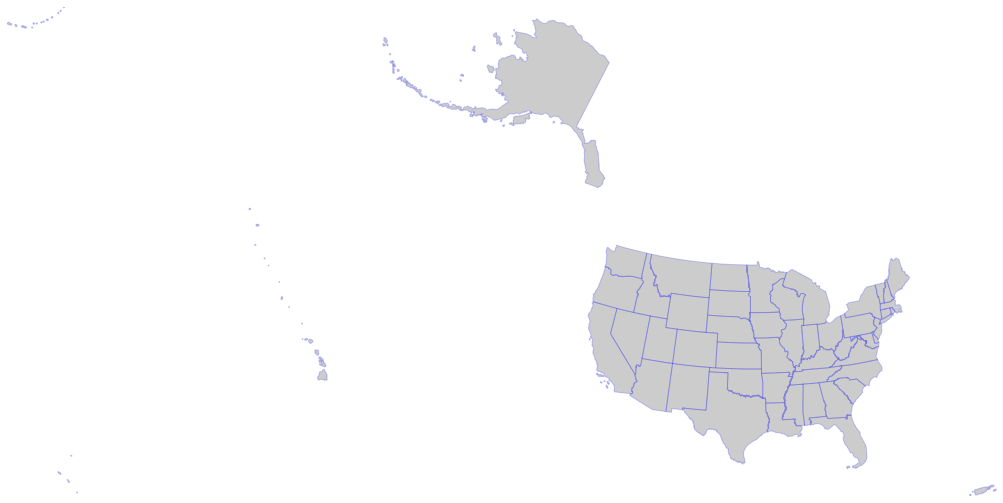

In [2]:
ax = state.to_crs(CRS).plot(**BASE_PLOT)
ax.axis("off")
ax.margins(0)

In [3]:
cfile = Path(root, "us_coastline.feather")
if cfile.exists():
    coastline = gpd.read_feather(cfile)
else:
    coastline = tiger_shp_2020("coastline")
    coastline.to_feather(cfile)

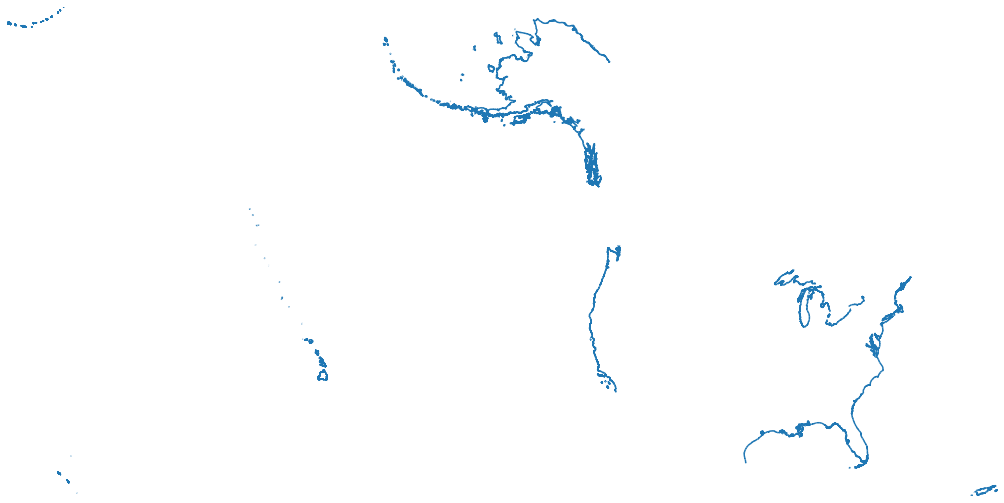

In [4]:
ax = coastline.to_crs(CRS).plot(figsize=(18, 9))
ax.axis("off")
ax.margins(0)

### Clip to CONUS

In [5]:
from shapely.geometry import box

conus_bounds = box(-125, 24, -65, 50)

cfile = Path(root, "conus_states.feather")
if cfile.exists():
    conus_states = gpd.read_feather(cfile)
else:
    conus_states = state[state.within(conus_bounds)]
    conus_states.to_feather(cfile)

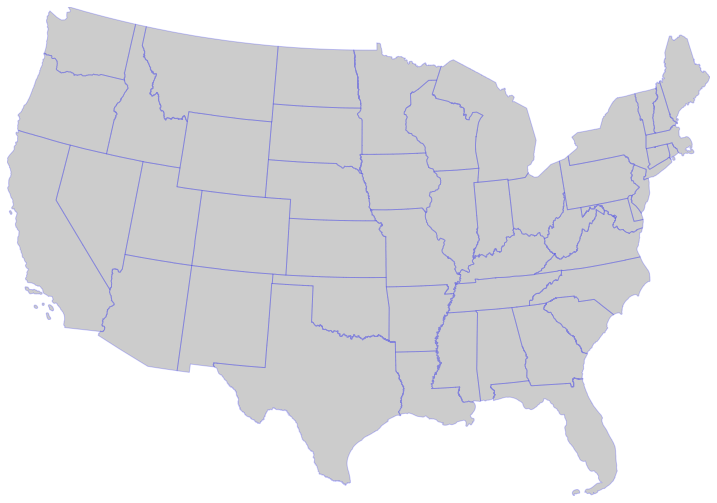

In [6]:
ax = conus_states.to_crs(CRS).plot(**BASE_PLOT)
ax.axis("off")
ax.margins(0)

In [7]:
conus_coastline = coastline[coastline.within(conus_bounds)]

cfile = Path(root, "us_coast_states.feather")
if cfile.exists():
    coast_states = gpd.read_feather(cfile)
else:
    coast_states = state[state.intersects(conus_coastline.unary_union)]
    coast_states.to_feather(cfile)

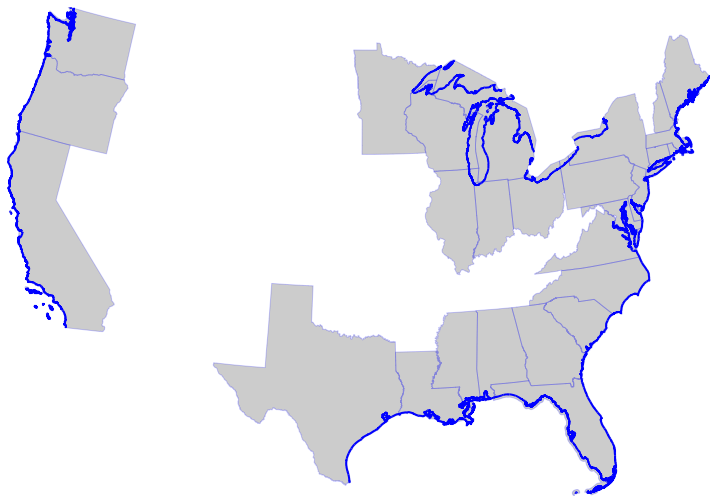

In [8]:
ax = coast_states.to_crs(CRS).plot(**BASE_PLOT)
conus_coastline.to_crs(CRS).plot(ax=ax, edgecolor="b", lw=2, zorder=1)
ax.axis("off")
ax.margins(0)

### Tidal and Estuary USGS stations

<img src="https://raw.githubusercontent.com/cheginit/HyRiver-examples/main/notebooks/_static/pygeohydro_logo.png" width="400"/>

We need to look at the [Water Services](https://waterservices.usgs.gov/rest/Site-Service.html) API.

In [9]:
import pandas as pd
from pygeohydro import NWIS, ZeroMatched

cfile = Path(root, "coast_stations.feather")
if cfile.exists():
    coast_stations = gpd.read_feather(cfile)
else:
    queries = [
        {
            "stateCd": s.lower(),
            "siteType": "ST-TS,ES",
            "hasDataTypeCd": "dv",
            "outputDataTypeCd": "dv",
        }
        for s in coast_states.STUSPS
    ]
    nwis = NWIS()

    def get_info(q):
        try:
            return nwis.get_info(q, True)
        except ZeroMatched:
            return None

    sites = pd.concat(get_info(q) for q in queries if q is not None)

    coast_stations = gpd.GeoDataFrame(
        sites,
        geometry=gpd.points_from_xy(sites.dec_long_va, sites.dec_lat_va),
        crs="epsg:4269",
    )
    coast_stations.to_feather(cfile)

st = coast_stations[["site_no", "site_tp_cd", "geometry"]].to_crs(CRS)
ts = st[st.site_tp_cd == "ST-TS"].drop_duplicates()
es = st[st.site_tp_cd == "ES"].drop_duplicates()

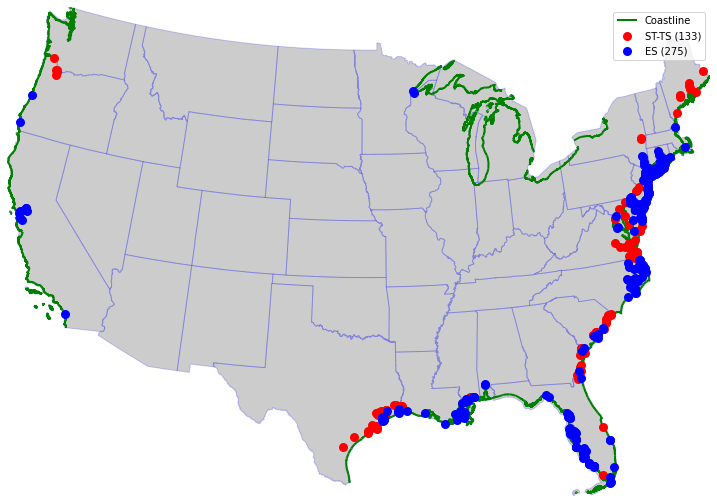

In [10]:
ax = conus_states.to_crs(CRS).plot(**BASE_PLOT)
coastline[coastline.within(conus_bounds)].to_crs(CRS).plot(ax=ax, edgecolor="g", lw=2, zorder=1)
ts.plot(ax=ax, lw=3, c="r")
es.plot(ax=ax, lw=3, c="b")
ax.legend(["Coastline", f"ST-TS ({ts.shape[0]})", f"ES ({es.shape[0]})"], loc="best")
ax.axis("off")
ax.margins(0)

### Mean daily discharge for all stations

In [11]:
import numpy as np
import pandas as pd

cfile = Path(root, "discharge.parquet")
dates = ("2000-01-01", "2015-12-31")

if cfile.exists():
    discharge = pd.read_parquet(cfile)
else:
    nwis = NWIS()
    discharge = nwis.get_streamflow(
        coast_stations.site_no,
        dates,
    )
    discharge[discharge < 0] = np.nan
    discharge.to_parquet(cfile)

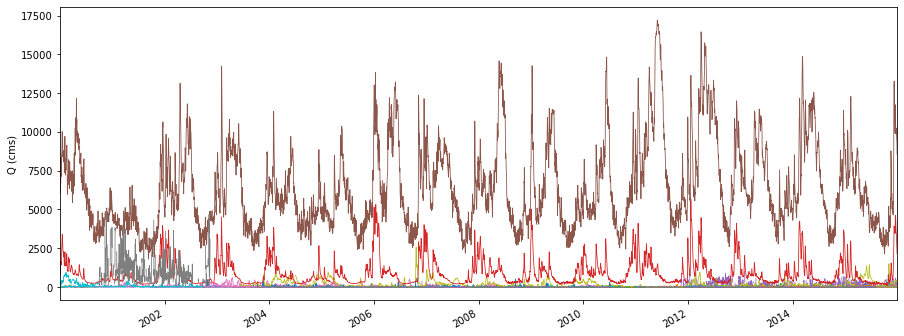

In [12]:
ax = discharge.plot(legend=False, lw=0.8, figsize=(15, 6))
ax.set_ylabel("Q (cms)")
ax.set_xlabel("")
ax.margins(x=0)

Let's find the station that has the largest peak value and see it on a map.

In [13]:
station_id = discharge.max().idxmax().split("-")[1]

coast_stations[coast_stations.site_no == station_id].iloc[0]["station_nm"]

'COLUMBIA RIVER AT PORT WESTWARD, NEAR QUINCY, OR'

In [14]:
import pygeohydro as gh

lat, lon = coast_stations[coast_stations.site_no == station_id].iloc[0][
    ["dec_lat_va", "dec_long_va"]
]
bbox = (lon - 0.2, lat - 0.2, lon + 0.2, lat + 0.2)
nwis_kwds = {"hasDataTypeCd": "dv", "outputDataTypeCd": "dv", "parameterCd": "00060"}

station_map = gh.interactive_map(bbox, nwis_kwds=nwis_kwds)

/Users/tchegini/.local/apps/mambaforge/envs/hyriver-dev/lib/python3.10/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


In [15]:
station_map

### River network data

<img src="https://raw.githubusercontent.com/cheginit/HyRiver-examples/main/notebooks/_static/pynhd_logo.png" width="400"/>


#### Basin

In [16]:
import pynhd as nhd

nldi = nhd.NLDI()
cfile = Path(root, "basin.feather")
if cfile.exists():
    basin = gpd.read_feather(cfile)
else:
    basin = nldi.get_basins(station_id)
    basin.to_feather(cfile)

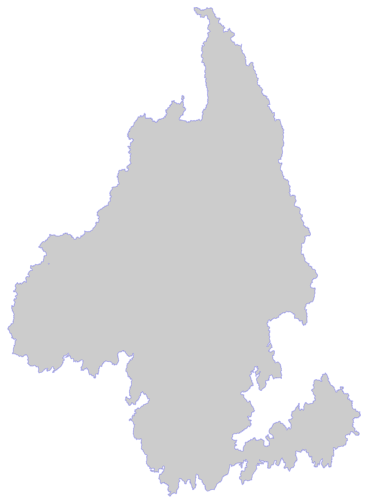

In [17]:
ax = basin.to_crs(CRS).plot(**BASE_PLOT)
ax.axis("off")
ax.margins(0)

In [18]:
import folium

folium.GeoJson(basin.geometry).add_to(station_map)
station_map

#### Main river network

In [19]:
cfile = Path(root, "flowline_main.feather")
if cfile.exists():
    flw_main = gpd.read_feather(cfile)
else:
    flw_main = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamMain",
        source="flowlines",
        distance=4000,
    )
    flw_main.to_feather(cfile)

#### Tributaries

In [20]:
cfile = Path(root, "flowline_trib.feather")
if cfile.exists():
    flw_trib = gpd.read_feather(cfile)
else:
    flw_trib = nldi.navigate_byid(
        fsource="nwissite",
        fid=f"USGS-{station_id}",
        navigation="upstreamTributaries",
        source="flowlines",
        distance=4000,
    )
    flw_trib.to_feather(cfile)
flw_trib["nhdplus_comid"] = flw_trib["nhdplus_comid"].astype("float").astype("Int64")

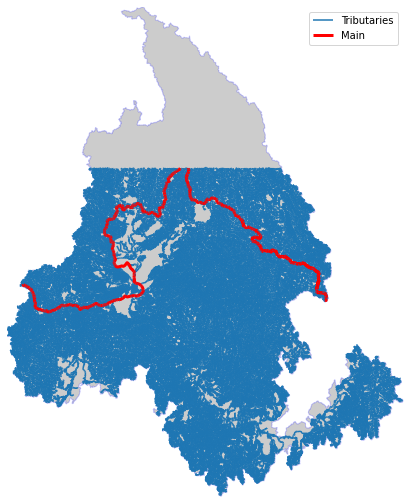

In [21]:
ax = basin.plot(**BASE_PLOT)
flw_trib.plot(ax=ax)
flw_main.plot(ax=ax, lw=3, color="r")
ax.legend(["Tributaries", "Main"])
ax.axis("off")
ax.margins(0)

#### NHDPlus Value Added Attributes (VAA)

In [22]:
cfile = Path(root, "nhdplus_vaa.parquet")
nhdplus_vaa = nhd.nhdplus_vaa(cfile)

flw_trib = flw_trib.merge(nhdplus_vaa, left_on="nhdplus_comid", right_on="comid", how="left")
flw_trib.loc[flw_trib.slope < 0, "slope"] = np.nan

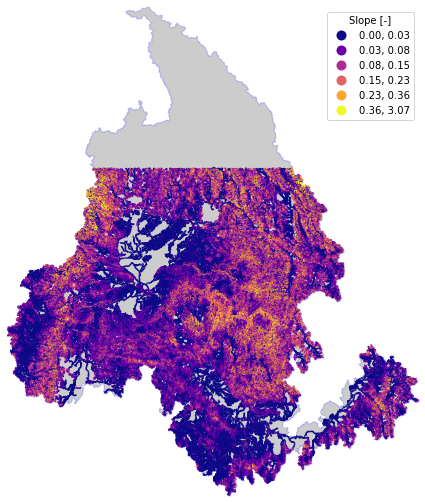

In [23]:
ax = basin.plot(**BASE_PLOT)
flw_trib.plot(
    ax=ax,
    column="slope",
    scheme="natural_breaks",
    k=6,
    cmap="plasma",
    legend=True,
    legend_kwds={"title": "Slope [-]"},
)
ax.axis("off")
ax.margins(0)